https://www.dataquest.io/blog/kaggle-tutorial/ -> use seaborn rather than default pandas plots

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event. Submissions are evaluated according to the [Mean Average Precision @ 5 (MAP@5)](https://www.kaggle.com/c/expedia-hotel-recommendations#evaluation)

In [40]:
import os
import random
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress chained_assignment warning, default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.decomposition import PCA
from itertools import chain

In [2]:
data_dir = '/Users/robincole/Documents/kaggle/Kaggle_Expedia_Hotel_Recommendations/'

In [3]:
os.listdir(data_dir)

['.DS_Store',
 'destinations.csv',
 'test.csv',
 'train.csv',
 'sample_submission.csv']

In [4]:
destinations = pd.read_csv(os.path.join(data_dir, "destinations.csv"))

In [5]:
test = pd.read_csv(os.path.join(data_dir, "test.csv"))
train = pd.read_csv(os.path.join(data_dir, "train.csv"))

## EDA (exploratory data analysis)
Loading `test` has maxed out the memory on my macbook..!

In [6]:
train.shape

(37670293, 24)

In [7]:
train.shape[0]/1e6

37.670293

We have 37 million rows of data in `train`

In [8]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


The descritpions of the column names are [here](https://www.kaggle.com/c/expedia-hotel-recommendations/data).

There are a few things that immediately stick out:
* `date_time` could be useful in our predictions, so we'll need to convert it.
* Most of the columns are integers or floats, so we can't do a lot of feature engineering. For example, `user_location_country` isn't the name of a country, it's an integer. This makes it harder to create new features, because we don't know exactly which each value means.

It looks like all the dates in `test.csv` are later than the dates in `train.csv`, and the data page confirms this. The testing set contains dates from 2015, and the training set contains dates from 2013 and 2014.
It looks like the user ids in `test.csv` are a subset of the user ids in `train.csv`, given the overlapping integer ranges. We can confirm this later on.
The is_booking column always looks to be 1 in `test.csv`. The data page confirms this.

/Users/robincole/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


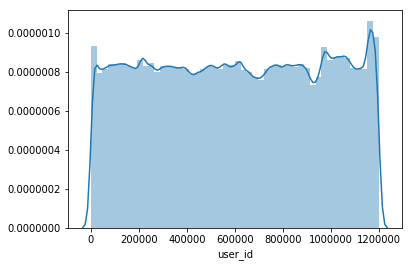

In [9]:
sns.distplot(train['user_id'])

In [10]:
test_ids = set(test.user_id.unique())
train_ids = set(train.user_id.unique())
intersection_count = len(test_ids & train_ids)
intersection_count == len(test_ids)

True

## Prediction target
We'll be predicting which `hotel_cluster` a user will book after a given search. According to the description, there are 100 clusters in total.

In [11]:
train['hotel_cluster'].unique().shape

(100,)

/Users/robincole/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


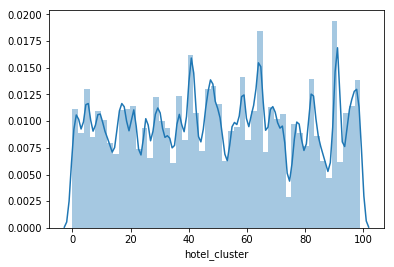

In [12]:
sns.distplot(train['hotel_cluster'])

Clusters are fairly evely distributed

## Evaluation
The evaluation page says that we'll be scored using Mean Average Precision @ 5, which means that we'll need to make 5 cluster predictions for each row, and will be scored on whether or not the correct prediction appears in our list. If the correct prediction comes earlier in the list, we get more points.

For example, if the "correct" cluster is 3, and we predict 4, 43, 60, 3, 20, our score will be lower than if we predict 3, 4, 43, 60, 20. We should put predictions we're more certain about earlier in our list of predictions.

## Downsampling our train data
The entire train.csv dataset contains 37 million rows, which makes it hard to experiment with different techniques. Ideally, we want a small enough dataset that lets us quickly iterate through different approaches but is still representative of the whole training data.
We can do this by first randomly sampling rows from our data, then selecting new training and testing datasets from train.csv. By selecting both sets from train.csv, we'll have the true hotel_cluster label for every row, and we'll be able to calculate our accuracy as we test techniques.

The first step is to add month and year fields to train. Because the train and test data is differentiated by date, we'll need to add date fields to allow us to segment our data into two sets the same way. If we add year and month fields, we can split our data into training and testing sets using them.
* Convert the date_time column in train from an object to a datetime value. This makes it easier to work with as a date.
* Extract the year and month from from date_time, and assign them to their own columns.

In [13]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

## Pick 10000 users
Because the user ids in test are a subset of the user ids in train, we'll need to do our random sampling in a way that preserves the full data of each user. We can accomplish this by selecting a certain number of users randomly, then only picking rows from train where user_id is in our random sample of user ids.

In [14]:
unique_users = train.user_id.unique() # get unique user ids

In [15]:
unique_users.shape

(1198786,)

In [16]:
sel_user_id = random.sample(list(unique_users), 10000)

In [17]:
sel_train = train[train.user_id.isin(sel_user_id)]

In [18]:
len(sel_train['user_id'].unique())

10000

The above code creates a DataFrame called sel_train that only contains data from 10000 users.

## Pick new training and testing sets
We'll now need to pick new training and testing sets from sel_train. We'll call these sets t1 and t2.

In [19]:
t1 = sel_train[((sel_train.year == 2013) | ((sel_train.year == 2014) & (sel_train.month < 8)))]
t2 = sel_train[((sel_train.year == 2014) & (sel_train.month >= 8))]

In the original train and test DataFrames, test contained data from 2015, and train contained data from 2013 and 2014. We split this data so that anything after July 2014 is in t2, and anything before is in t1. This gives us smaller training and testing sets with similar characteristics to train and test.

## Remove click events
If is_booking is 0, it represents a click, and a 1 represents a booking. test contains only booking events, so we'll need to sample t2 to only contain bookings as well.

In [20]:
t2 = t2[t2.is_booking == True]

## Benchmark with a simple algorithm
The most simple technique we could try on this data is to find the most common clusters across the data, then use them as predictions.

We can again use the value_counts method to help us here:

In [21]:
most_common_clusters = list(train.hotel_cluster.value_counts().head().index)

In [22]:
most_common_clusters

[91, 41, 48, 64, 65]

The above code will give us a list of the 5 most common clusters in train. This is because the head method returns the first 5 rows by default, and the index property will return the index of the DataFrame, which is the hotel cluster after running the value_counts method.

## Generating predictions
We can turn most_common_clusters into a list of predictions by making the same prediction for each row.

In [23]:
predictions = [most_common_clusters for i in range(t2.shape[0])]

## Evaluating error
In order to evaluate error, we'll first need to figure out how to compute Mean Average Precision. Luckily, Ben Hamner has written an implementation that can be found here. It can be installed as part of the [ml_metrics package](https://pypi.org/project/ml_metrics/), and you can find installation instructions for how to install it here.

We can compute our error metric with the mapk method in ml_metrics:

In [24]:
# !pip install ml_metrics

In [25]:
import ml_metrics as metrics
target = [[l] for l in t2["hotel_cluster"]]
metrics.mapk(target, predictions, k=5)

0.06433873961107077

Our target needs to be in list of lists format for mapk to work, so we convert the hotel_cluster column of t2 into a list of lists. Then, we call the mapk method with our target, our predictions, and the number of predictions we want to evaluate (5).

Our result here isn't great, but we've just generated our first set of predictions, and evaluated our error! The framework we've built will allow us to quickly test out a variety of techniques and see how they score. We're well on our way to building a good-performing solution for the leaderboard.

## Finding correlations
Before we move on to creating a better algorithm, let's see if anything correlates well with hotel_cluster. This will tell us if we should dive more into any particular columns.

We can find linear correlations in the training set using the corr method:

In [26]:
train.corr()["hotel_cluster"]

site_name                   -0.022408
posa_continent               0.014938
user_location_country       -0.010477
user_location_region         0.007453
user_location_city           0.000831
orig_destination_distance    0.007260
user_id                      0.001052
is_mobile                    0.008412
is_package                   0.038733
channel                      0.000707
srch_adults_cnt              0.012309
srch_children_cnt            0.016261
srch_rm_cnt                 -0.005954
srch_destination_id         -0.011712
srch_destination_type_id    -0.032850
is_booking                  -0.021548
cnt                          0.002944
hotel_continent             -0.013963
hotel_country               -0.024289
hotel_market                 0.034205
hotel_cluster                1.000000
year                        -0.001050
month                       -0.000560
Name: hotel_cluster, dtype: float64

Wow that literally crashed my computer first time. 

This tells us that no columns correlate linearly with hotel_cluster. This makes sense, because there is no linear ordering to hotel_cluster. For example, having a higher cluster number isn't tied to having a higher srch_destination_id.

Unfortunately, this means that techniques like linear regression and logistic regression won't work well on our data, because they rely on linear correlations between predictors and targets.

## Creating better predictions for our Kaggle entry
This data for this competition is quite difficult to make predictions on using machine learning for a few reasons:

* There are millions of rows, which increases runtime and memory usage for algorithms.
* There are 100 different clusters, and according to the competition admins, the boundaries are fairly fuzzy, so it will likely be hard to make predictions. As the number of clusters increases, classifiers generally decrease in accuracy.
* Nothing is linearly correlated with the target (hotel_clusters), meaning we can't use fast machine learning techniques like linear regression.

For these reasons, machine learning probably won't work well on our data, but we can try an algorithm and find out.

## Generating features
The first step in applying machine learning is to generate features. We can generate features using both what's available in the training data, and what's available in destinations. We haven't looked at destinations yet, so let's take a quick peek.

### Generating features from destinations
Destinations contains an id that corresponds to srch_destination_id, along with 149 columns of latent information about that destination. Here's a sample:

In [27]:
destinations.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [28]:
destinations.shape

(62106, 150)

The competition doesn't tell us exactly what each latent feature is, but it's safe to assume that it's some combination of destination characteristics, like name, description, and more. These latent features were converted to numbers, so they could be anonymized.

## PCA
We can use the destination information as features in a machine learning algorithm, but we'll need to compress the number of columns down first, to minimize runtime. We can use PCA to do this. PCA will reduce the number of columns in a matrix while trying to preserve the same amount of variance per row. Ideally, PCA will compress all the information contained in all the columns into less, but in practice, some information is lost.

In the code below, we:

* Initialize a PCA model using scikit-learn.
* Specify that we want to only have 3 columns in our data.
* Transform the columns d1-d149 into 3 columns.

In [29]:
pca = PCA(n_components=3)
dest_small = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = destinations["srch_destination_id"]

In [31]:
dest_small.head()

,0,1,2,srch_destination_id
0,-0.044268,0.169419,0.032527,0
1,-0.440761,0.077405,-0.091574,1
2,0.001033,0.020677,0.012109,2
3,-0.480467,-0.040345,-0.019318,3
4,-0.207253,-0.042694,-0.011743,4


The above code compresses the 149 columns in destinations down to 3 columns, and creates a new DataFrame called `dest_small`. We preserve most of the variance in destinations while doing this, so we don't lose a lot of information, but save a lot of runtime for a machine learning algorithm.

## Generating features
Now that the preliminaries are done with, we can generate our features. We'll do the following:

* Generate new date features based on date_time, srch_ci, and srch_co.
* Remove non-numeric columns like date_time.
* Add in features from dest_small.
* Replace any missing values with -1.

In [32]:
def calc_fast_features(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
        
    ret = pd.DataFrame(props)
    
    ret = ret.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_iddest", axis=1)
    return ret

The above will calculate features such as length of stay, check in day, and check out month. These features will help us train a machine learning algorithm later on.

Replacing missing values with -1 isn't the best choice, but it will work fine for now, and we can always optimize the behavior later on.

In [33]:
%%time
df = calc_fast_features(t1)
df.fillna(-1, inplace=True)

/Users/robincole/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/robincole/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/robincole/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

CPU times: user 643 ms, sys: 943 ms, total: 1.59 s
Wall time: 2.21 s


In [34]:
df.head()

,month,day,hour,minute,dayofweek,quarter,site_name,posa_continent,user_location_country,user_location_region,...,ci_day,co_day,ci_dayofweek,co_dayofweek,ci_quarter,co_quarter,stay_span,0,1,2
4848,3,12,4,4,2,1,2,3,69,724,...,30.0,31.0,6.0,0.0,1.0,1.0,24.0,-0.167024,-0.036762,-0.004067
4849,3,13,4,40,3,1,2,3,69,724,...,30.0,31.0,6.0,0.0,1.0,1.0,24.0,0.718538,-0.363431,-0.144464
4850,3,13,4,40,3,1,2,3,69,724,...,2.0,3.0,2.0,3.0,2.0,2.0,24.0,0.718538,-0.363431,-0.144464
4851,3,13,4,43,3,1,2,3,69,724,...,2.0,3.0,2.0,3.0,2.0,2.0,24.0,0.594870,-0.320752,-0.197983
4852,3,13,12,9,3,1,2,3,69,724,...,2.0,3.0,2.0,3.0,2.0,2.0,24.0,-0.217999,-0.104573,0.071984


## Machine learning
Now that we have features for our training data, we can try machine learning. We'll use 3-fold cross validation across the training set to generate a reliable error estimate. Cross validation splits the training set up into 3 parts, then predicts hotel_cluster for each part using the other parts to train with.

We'll generate predictions using the Random Forest algorithm. Random forests build trees, which can fit to nonlinear tendencies in data. This will enable us to make predictions, even though none of our columns are linearly related.

We'll first initialize the model and compute cross validation scores:

In [35]:
predictors = [c for c in df.columns if c not in ["hotel_cluster"]]
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)

/Users/robincole/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
%%time
scores = cross_validation.cross_val_score(clf, df[predictors], df['hotel_cluster'], cv=3)

CPU times: user 3.18 s, sys: 487 ms, total: 3.66 s
Wall time: 3.77 s


In [37]:
scores

array([0.06618243, 0.06741843, 0.06781036])

The above code doesn't give us very good accuracy, and confirms our original suspicion that machine learning isn't a great approach to this problem. However, classifiers tend to have lower accuracy when there is a high cluster count. We can instead try training 100 binary classifiers. Each classifier will just determine if a row is in it's cluster, or not. This will entail training one classifier per label in hotel_cluster.

## Binary classifiers
We'll again train Random Forests, but each forest will predict only a single hotel cluster. We'll use 2 fold cross validation for speed, and only train 10 trees per label.

In the code below, we:

* Loop across each unique hotel_cluster.
* Train a Random Forest classifier using 2-fold cross validation.
* Extract the probabilities from the classifier that the row is in the unique hotel_cluster
* Combine all the probabilities.
* For each row, find the 5 largest probabilities, and assign those hotel_cluster values as predictions.
* Compute accuracy using mapk.

In [41]:
%%time

all_probs = []
unique_clusters = df["hotel_cluster"].unique()
for cluster in unique_clusters:
    df["target"] = 1
    df["target"][df["hotel_cluster"] != cluster] = 0
    predictors = [col for col in df if col not in ['hotel_cluster', "target"]]
    probs = []
    cv = KFold(len(df["target"]), n_folds=2)
    clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
    for i, (tr, te) in enumerate(cv):
        clf.fit(df[predictors].iloc[tr], df["target"].iloc[tr])
        preds = clf.predict_proba(df[predictors].iloc[te])
        probs.append([p[1] for p in preds])
    full_probs = chain.from_iterable(probs)
    all_probs.append(list(full_probs))

prediction_frame = pd.DataFrame(all_probs).T
prediction_frame.columns = unique_clusters
def find_top_5(row):
    return list(row.nlargest(5).index)

CPU times: user 1min 51s, sys: 9.88 s, total: 2min 1s
Wall time: 2min 2s


In [43]:
%%time
preds = []
for index, row in prediction_frame.iterrows():
    preds.append(find_top_5(row))

metrics.mapk([[l] for l in t2.iloc["hotel_cluster"]], preds, k=5)

TypeError: cannot do positional indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [hotel_cluster] of <class 'str'>

`0.041083333333333326`

Our accuracy here is worse than before, and people on the leaderboard have much better accuracy scores. We'll need to abandon machine learning and move to the next technique in order to compete. Machine learning can be a powerful technique, but it isn't always the right approach to every problem.

## Top clusters based on hotel_cluster
There are a few Kaggle Kernels for the competition that involve aggregating hotel_cluster based on orig_destination_distance, or srch_destination_id. Aggregating on orig_destination_distance will exploit a data leak in the competition, and attempt to match the same user together. Aggregating on srch_destination_id will find the most popular hotel clusters for each destination. We'll then be able to predict that a user who searches for a destination is going to one of the most popular hotel clusters for that destination. Think of this as a more granular version of the most common clusters technique we used earlier.

We can first generate scores for each hotel_cluster in each srch_destination_id. We'll weight bookings higher than clicks. This is because the test data is all booking data, and this is what we want to predict. We want to include click information, but downweight it to reflect this. Step by step, we'll:

* Group t1 by srch_destination_id, and hotel_cluster.
* Iterate through each group, and:
* Assign 1 point to each hotel cluster where is_booking is True.
* Assign .15 points to each hotel cluster where is_booking is False.
* Assign the score to the srch_destination_id / hotel_cluster combination in a dictionary.

Here's the code to accomplish the above steps:

In [44]:
def make_key(items):
    return "_".join([str(i) for i in items])

match_cols = ["srch_destination_id"]
cluster_cols = match_cols + ['hotel_cluster']
groups = t1.groupby(cluster_cols)
top_clusters = {}
for name, group in groups:
    clicks = len(group.is_booking[group.is_booking == False])
    bookings = len(group.is_booking[group.is_booking == True])
    
    score = bookings + .15 * clicks
    
    clus_name = make_key(name[:len(match_cols)])
    if clus_name not in top_clusters:
        top_clusters[clus_name] = {}
    top_clusters[clus_name][name[-1]] = score

We have a dictionary where each key is an srch_destination_id. Each value in the dictionary will be another dictionary, containing hotel clusters as keys with scores as values. Here's how it looks:

In [47]:
top_clusters['1']

{20: 0.15, 30: 0.15, 60: 0.3}

We'll next want to transform this dictionary to find the top 5 hotel clusters for each srch_destination_id. In order to do this, we'll:

* Loop through each key in top_clusters.
* Find the top 5 clusters for that key.
* Assign the top 5 clusters to a new dictionary, cluster_dict.

Here's the code:

In [48]:
import operator

cluster_dict = {}
for n in top_clusters:
    tc = top_clusters[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    cluster_dict[n] = top

In [50]:
cluster_dict['1']

[60, 20, 30]

## Making predictions based on destination
Once we know the top clusters for each srch_destination_id, we can quickly make predictions. To make predictions, all we have to do is:

Iterate through each row in t2.
Extract the srch_destination_id for the row.
Find the top clusters for that destination id.
Append the top clusters to preds.
Here's the code:

In [51]:
preds = []
for index, row in t2.iterrows():
    key = make_key([row[m] for m in match_cols])
    if key in cluster_dict:
        preds.append(cluster_dict[key])
    else:
        preds.append([])

At the end of the loop, preds will be a list of lists containing our predictions.

In [52]:
preds[0]

[71, 34, 77, 16, 18]

## Calculating error
Once we have our predictions, we can compute our accuracy using the mapk function from earlier:

In [53]:
metrics.mapk([[l] for l in t2["hotel_cluster"]], preds, k=5)

0.22877834261276528

We boosted our accuracy 4x over the best machine learning approach, and we did it with a far faster and simpler approach.

You may have noticed that this value is quite a bit lower than accuracies [on the leaderboard](https://www.kaggle.com/c/expedia-hotel-recommendations/leaderboard). Local testing results in a lower accuracy value than submitting, so this approach will actually do fairly well on the leaderboard. Differences in leaderboard score and local score can come down to a few factors:

* Different data locally and in the hidden set that leaderboard scores are computed on. For example, we're computing error in a sample of the training set, and the leaderboard score is computed on the testing set.
* Techniques that result in higher accuracy with more training data. We're only using a small subset of data for training, and it may be more accurate when we use the full training set.
* Different randomization. With certain algorithms, random numbers are involved, but we're not using any of these.

## Generating better predictions for your Kaggle submission
The forums are very important in Kaggle, and can often help you find nuggets of information that will let you boost your score. The Expedia competition is no exception. [This post](https://www.kaggle.com/c/expedia-hotel-recommendations/discussion/20345) details a data leak that allows you to match users in the training set from the testing set using a set of columns including user_location_country, and user_location_region.

We'll use the information from the post to match users from the testing set back to the training set, which will boost our score. Based on the forum thread, its okay to do this, and the competition won't be updated as a result of the leak.

## Finding matching users
The first step is to find users in the training set that match users in the testing set.

In order to do this, we need to:

* Split the training data into groups based on the match columns.
* Loop through the testing data.
* Create an index based on the match columns.
* Get any matches between the testing data and the training data using the groups.

Here's the code to accomplish this:

In [56]:
match_cols = ['user_location_country', 'user_location_region', 'user_location_city', 'hotel_market', 'orig_destination_distance']

groups = t1.groupby(match_cols)
    
def generate_exact_matches(row, match_cols):
    index = tuple([row[t] for t in match_cols])
    try:
        group = groups.get_group(index)
    except Exception:
        return []
    clus = list(set(group.hotel_cluster))
    return clus

exact_matches = []
for i in range(t2.shape[0]):
    exact_matches.append(generate_exact_matches(t2.iloc[i], match_cols))

At the end of this loop, we'll have a list of lists that contain any exact matches between the training and the testing sets. However, there aren't that many matches. To accurately evaluate error, we'll have to combine these predictions with our earlier predictions. Otherwise, we'll get a very low accuracy value, because most rows have empty lists for predictions.

In [57]:
len(exact_matches)

8262

In [58]:
exact_matches[0]

[18]

## Combining predictions
We can combine different lists of predictions to boost accuracy. Doing so will also help us see how good our exact match strategy is. To do this, we'll have to:

* Combine exact_matches, preds, and most_common_clusters.
* Only take the unique predictions, in sequential order, using the f5 function from here.
* Ensure we have a maximum of 5 predictions for each row in the testing set.

Here's how we can do it:

In [61]:
def f5(seq, idfun=None): 
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result
    
full_preds = [f5(exact_matches[p] + preds[p] + most_common_clusters)[:5] for p in range(len(preds))]
metrics.mapk([[l] for l in t2["hotel_cluster"]], full_preds, k=5)

0.26733034777697084

This is looking quite good in terms of error -- we improved dramatically from earlier! We could keep going and making more small improvements, but we're probably ready to submit now.

## Making a Kaggle submission file
Luckily, because of the way we wrote the code, all we have to do to submit is assign train to the variable t1, and test to the variable t2. Then, we just have to re-run the code to make predictions. Re-running the code over the train and test sets should take less than an hour.

Once we have predictions, we just have to write them to a file:
```python
write_p = [" ".join([str(l) for l in p]) for p in full_preds]
write_frame = ["{0},{1}".format(t2["id"][i], write_p[i]) for i in range(len(full_preds))]
write_frame = ["id,hotel_clusters"] + write_frame
with open("predictions.csv", "w+") as f:
    f.write("\n".join(write_frame))
```
We'll then have a submission file in the right format to submit. As of this writing, making this submission will get you into the top 15.

In [59]:
%%time
write_p = [" ".join([str(l) for l in p]) for p in full_preds]
write_frame = ["{0},{1}".format(t2["id"][i], write_p[i]) for i in range(len(full_preds))]
write_frame = ["id,hotel_clusters"] + write_frame

with open("predictions.csv", "w+") as f:
    f.write("\n".join(write_frame))

NameError: name 'full_preds' is not defined

## Summary
We came a long way in this post! We went from just looking at the data all the way to creating a submission and getting onto the leaderboard. Along the way, some of the key steps we took were:

* Exploring the data and understanding the problem. (EDA)
* Setting up a way to iterate quickly through different techniques.
* Creating a way to figure out accuracy locally.
* Reading the forums, scripts, and the descriptions of the contest very closely to better understand the structure of the data.
* Trying a variety of techniques and not being afraid to not use machine learning.

## Next Steps
In order to iterate quickly and explore techniques, speed is key. This is difficult with this competition, but there are a few strategies to try:

* Sampling down the data even more.
* Parallelizing operations across multiple cores.
* Using Spark or other tools where tasks can be run on parallel workers.
* Exploring various ways to write code and benchmarking to find the most efficient approach.
* Avoiding iterating over the full training and testing sets, and instead using groups.
* Writing fast, efficient code is a huge advantage in this competition.